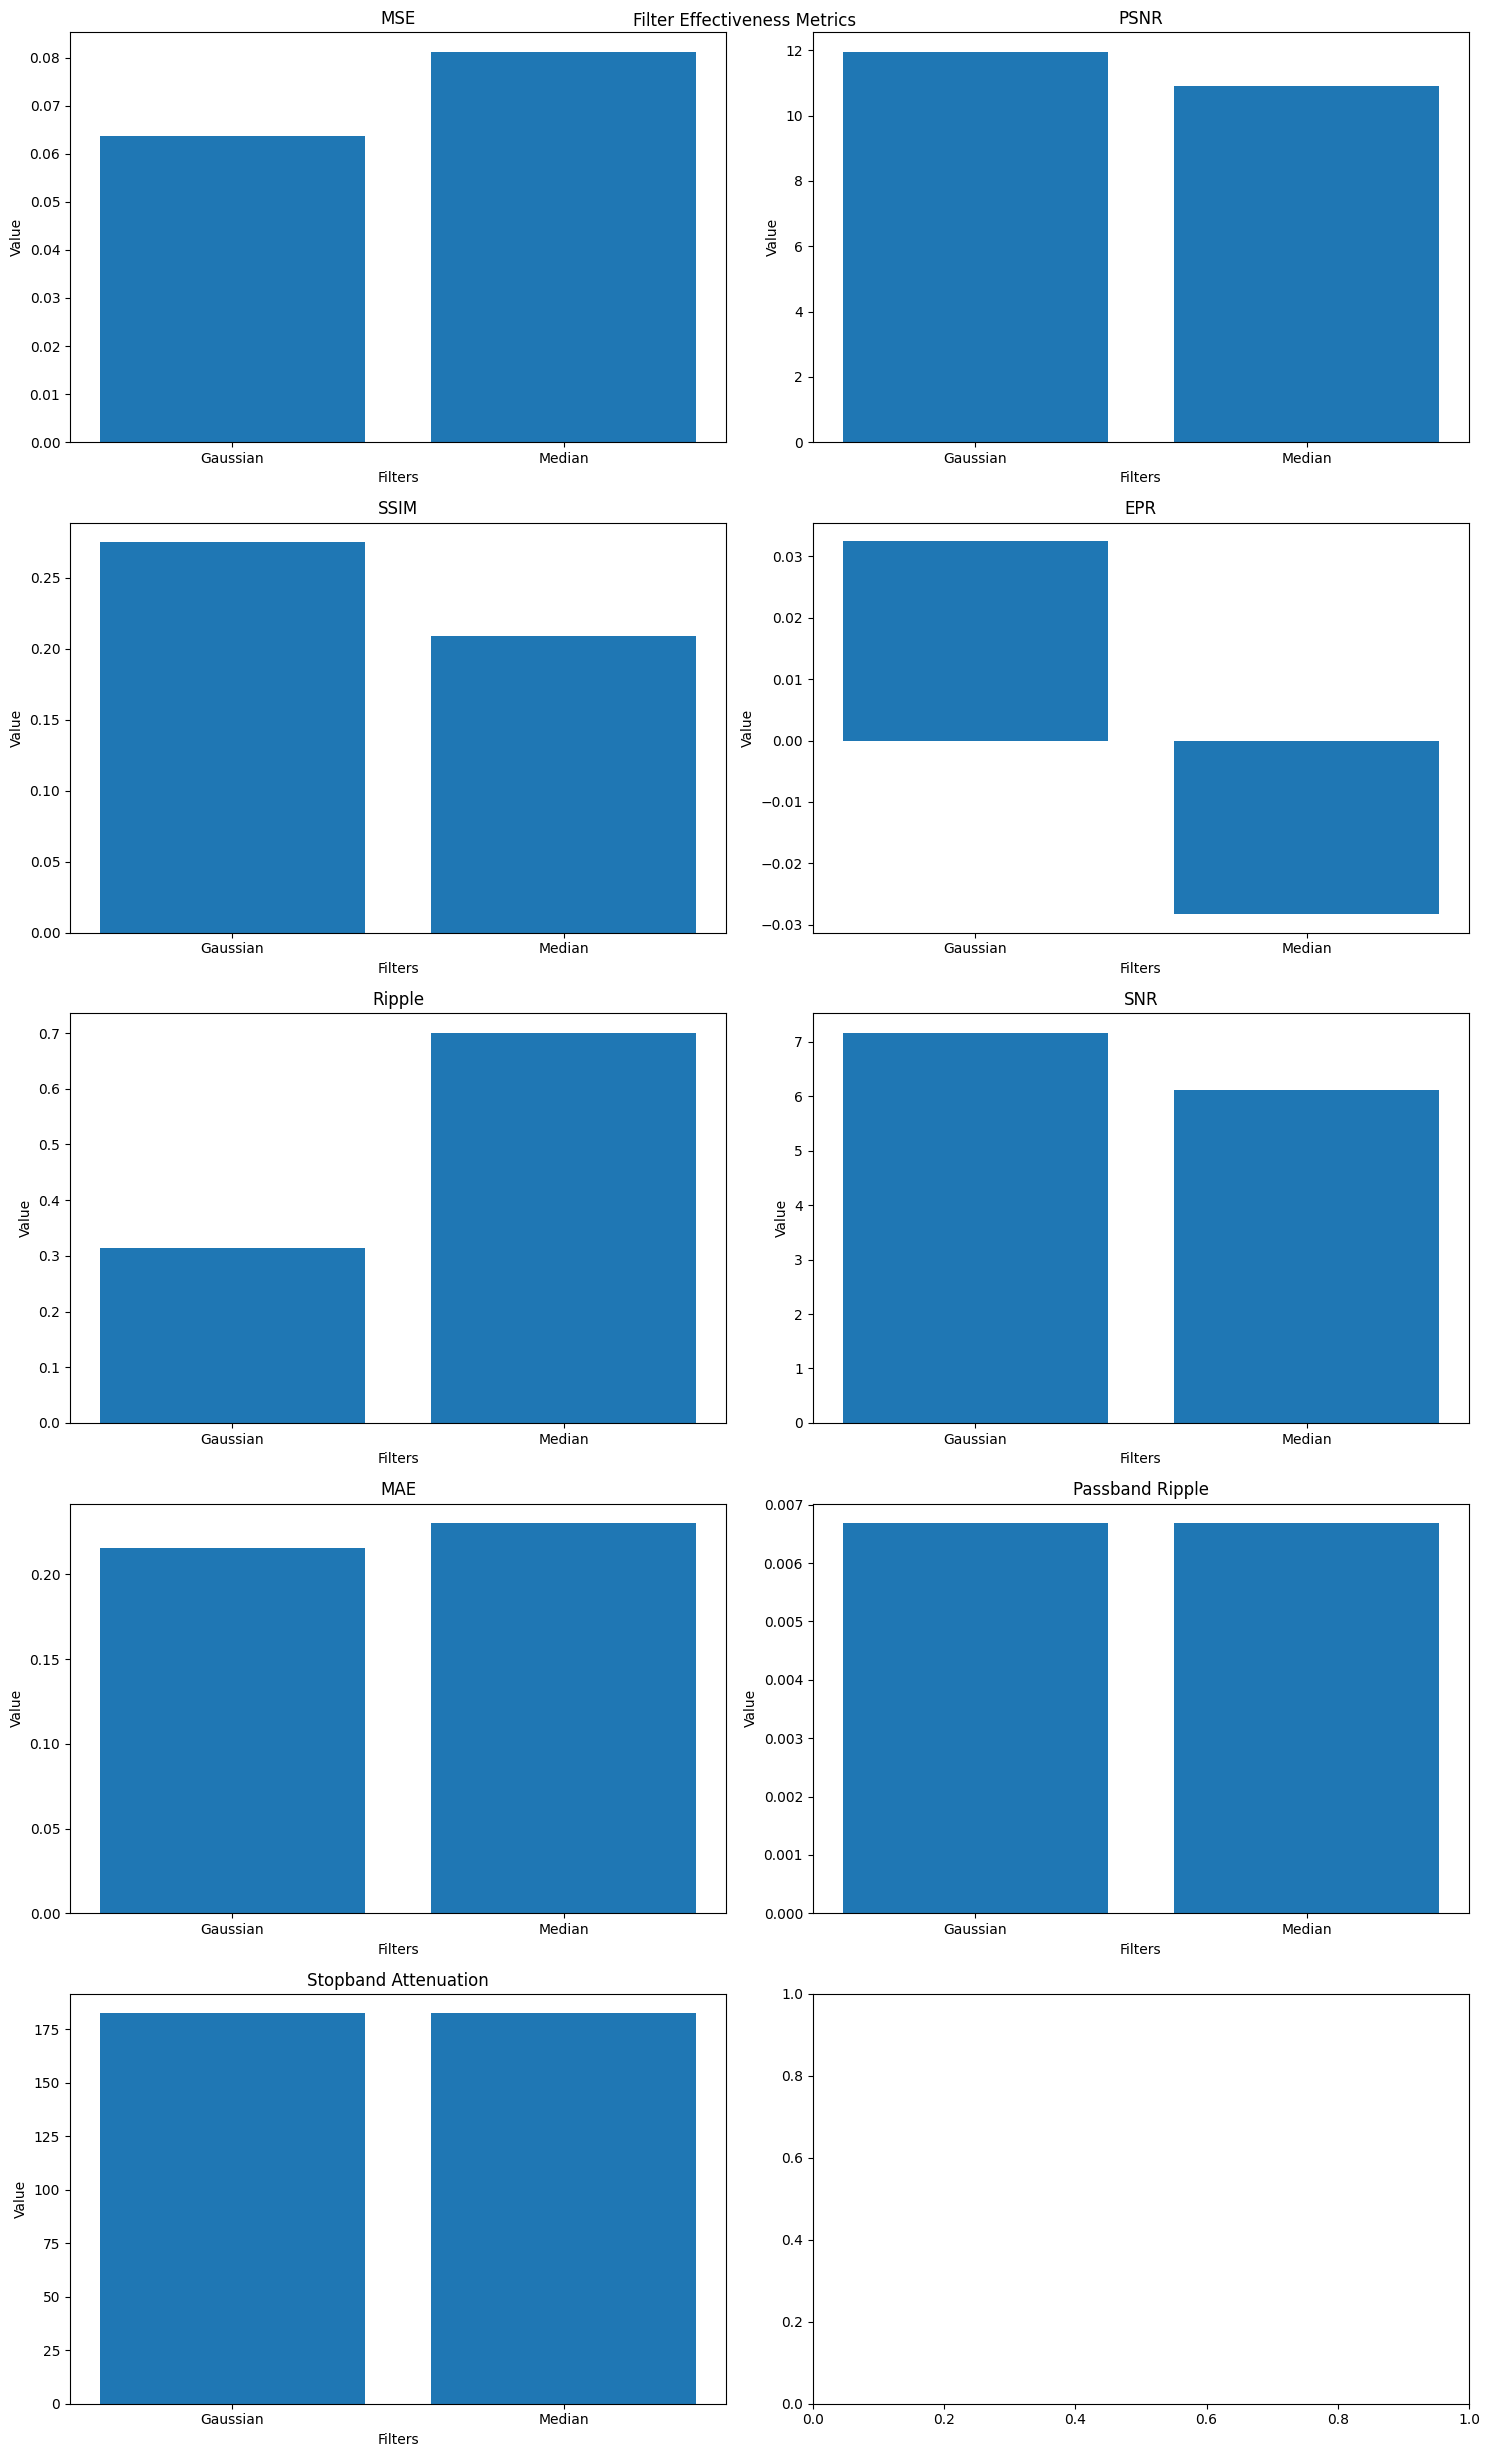

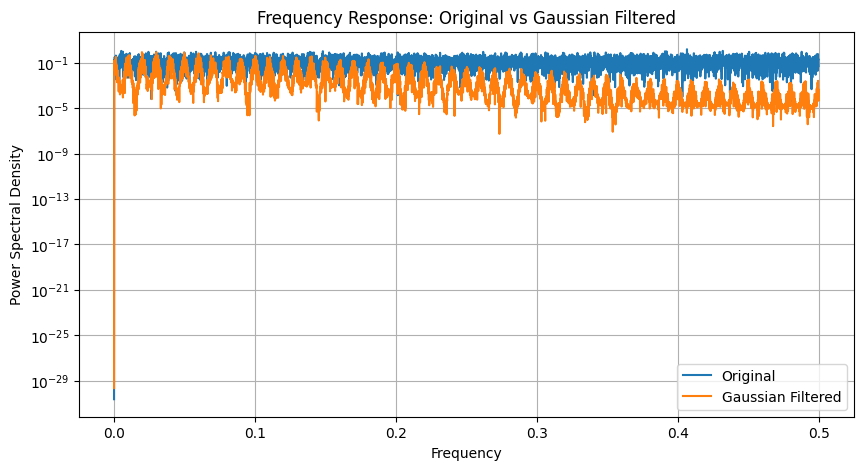

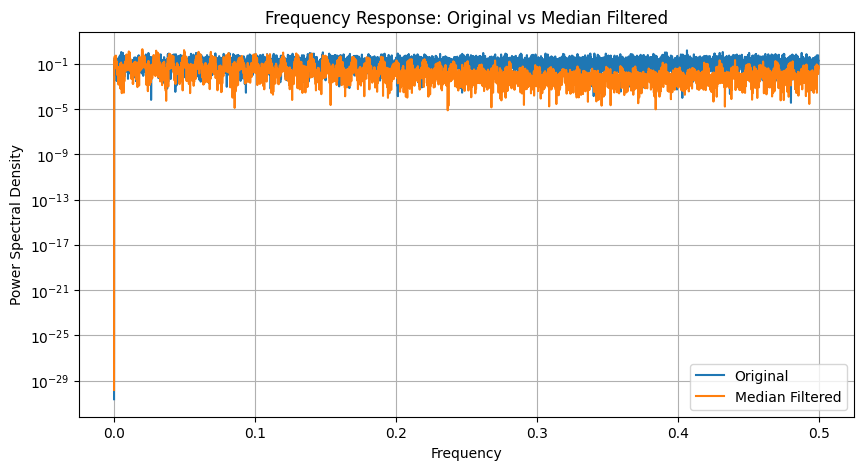

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy import ndimage, signal
from skimage.util import random_noise

def calculate_metrics(original, filtered):
    """Calculate various metrics to measure filter effectiveness."""
    # Mean Squared Error (MSE)
    mse = np.mean((original - filtered) ** 2)
    
    # Peak Signal-to-Noise Ratio (PSNR)
    psnr_value = psnr(original, filtered)
    
    # Structural Similarity Index (SSIM)
    ssim_value = ssim(original, filtered, data_range=original.max() - original.min())
    
    # Edge Preservation Ratio (EPR)
    laplacian_original = ndimage.laplace(original)
    laplacian_filtered = ndimage.laplace(filtered)
    epr = np.sum(laplacian_filtered * laplacian_original) / np.sum(laplacian_original ** 2)
    
    # Ripple measure (in frequency domain)
    f, Pxx_orig = signal.periodogram(original.flatten())
    f, Pxx_filt = signal.periodogram(filtered.flatten())
    ripple = np.std(Pxx_filt) / np.std(Pxx_orig)
    
    # Signal-to-Noise Ratio (SNR)
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - filtered) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(original - filtered))
    
    # Frequency Response Analysis
    f, h = signal.freqz(signal.firwin(len(original.flatten()), 0.5))
    freq_response = 20 * np.log10(np.abs(h))
    passband_ripple = np.max(freq_response) - np.min(freq_response[:len(freq_response)//2])
    stopband_attenuation = -np.min(freq_response[len(freq_response)//2:])
    
    return {
        'MSE': mse,
        'PSNR': psnr_value,
        'SSIM': ssim_value,
        'EPR': epr,
        'Ripple': ripple,
        'SNR': snr,
        'MAE': mae,
        'Passband Ripple': passband_ripple,
        'Stopband Attenuation': stopband_attenuation
    }

def plot_metrics(metrics_list, filter_names):
    """Plot the metrics for different filters."""
    metrics = list(metrics_list[0].keys())
    num_metrics = len(metrics)
    
    fig, axs = plt.subplots((num_metrics + 1) // 2, 2, figsize=(15, 5 * ((num_metrics + 1) // 2)))
    fig.suptitle('Filter Effectiveness Metrics')
    
    for idx, metric in enumerate(metrics):
        row = idx // 2
        col = idx % 2
        values = [m[metric] for m in metrics_list]
        axs[row, col].bar(filter_names, values)
        axs[row, col].set_title(metric)
        axs[row, col].set_xlabel('Filters')
        axs[row, col].set_ylabel('Value')
        
        # Rotate x-axis labels if there are many filters
        if len(filter_names) > 5:
            plt.setp(axs[row, col].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

def plot_frequency_response(original, filtered, filter_name):
    """Plot the frequency response of the original and filtered signals."""
    f, Pxx_orig = signal.periodogram(original.flatten())
    f, Pxx_filt = signal.periodogram(filtered.flatten())
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx_orig, label='Original')
    plt.semilogy(f, Pxx_filt, label=f'{filter_name} Filtered')
    plt.title(f'Frequency Response: Original vs {filter_name} Filtered')
    plt.xlabel('Frequency')
    plt.ylabel('Power Spectral Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate a sample image and add noise
    original = np.random.rand(100, 100)
    noisy = random_noise(original, mode='gaussian', var=0.01)
    
    # Apply different filters (this is just an example, replace with your actual filters)
    gaussian_filter = ndimage.gaussian_filter(noisy, sigma=1)
    median_filter = ndimage.median_filter(noisy, size=3)
    
    # Calculate metrics
    metrics_gaussian = calculate_metrics(original, gaussian_filter)
    metrics_median = calculate_metrics(original, median_filter)
    
    # Plot metrics
    plot_metrics([metrics_gaussian, metrics_median], ['Gaussian', 'Median'])
    
    # Plot frequency responses
    plot_frequency_response(original, gaussian_filter, 'Gaussian')
    plot_frequency_response(original, median_filter, 'Median')

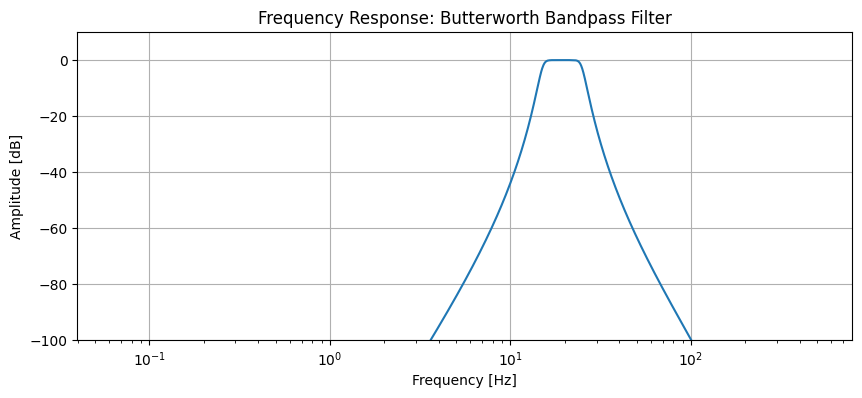

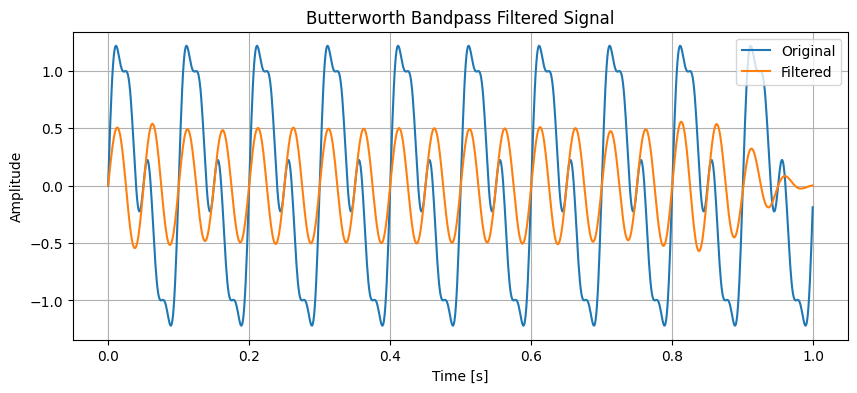

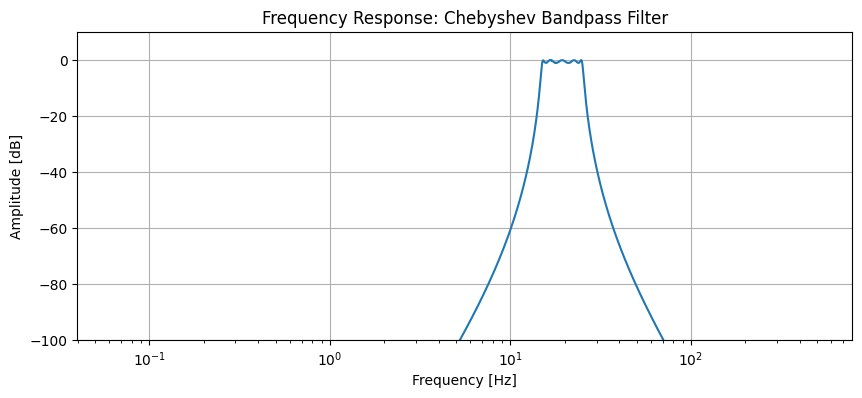

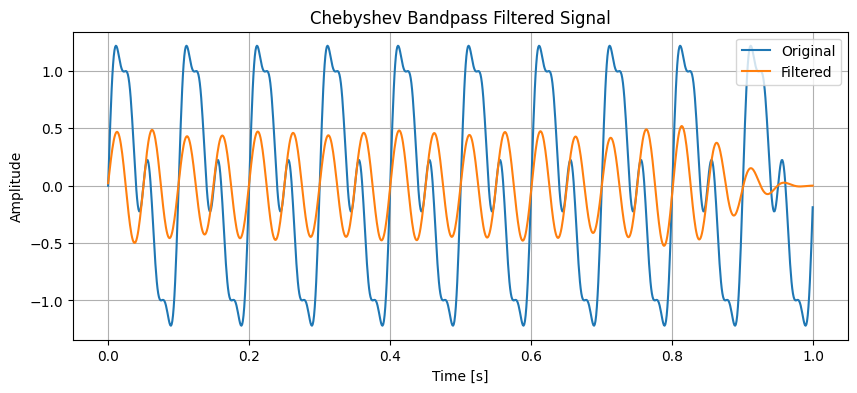

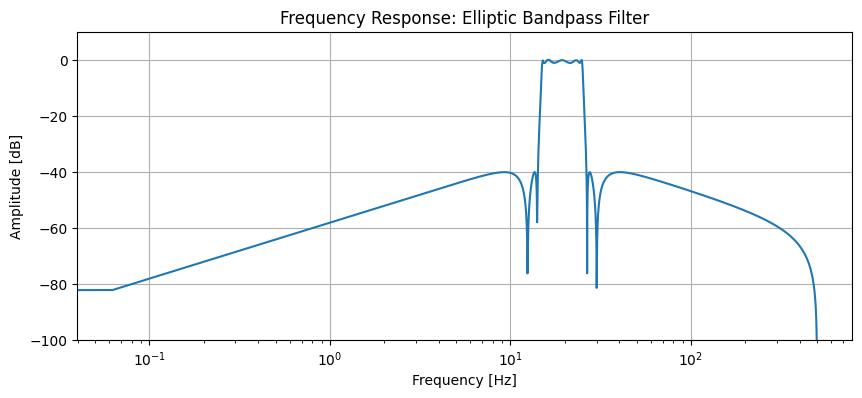

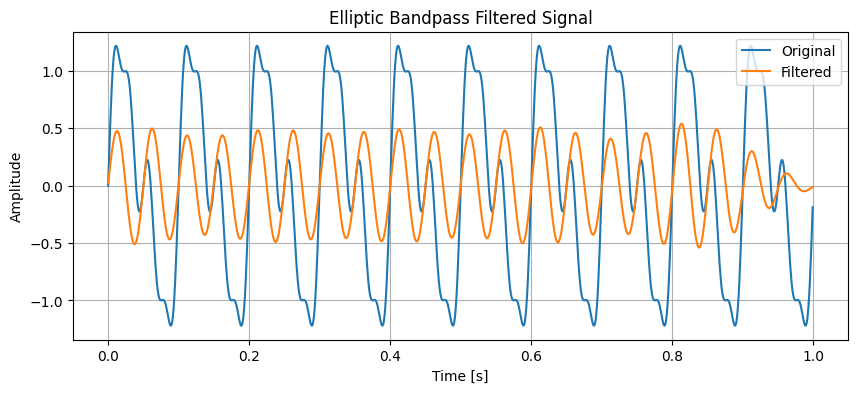

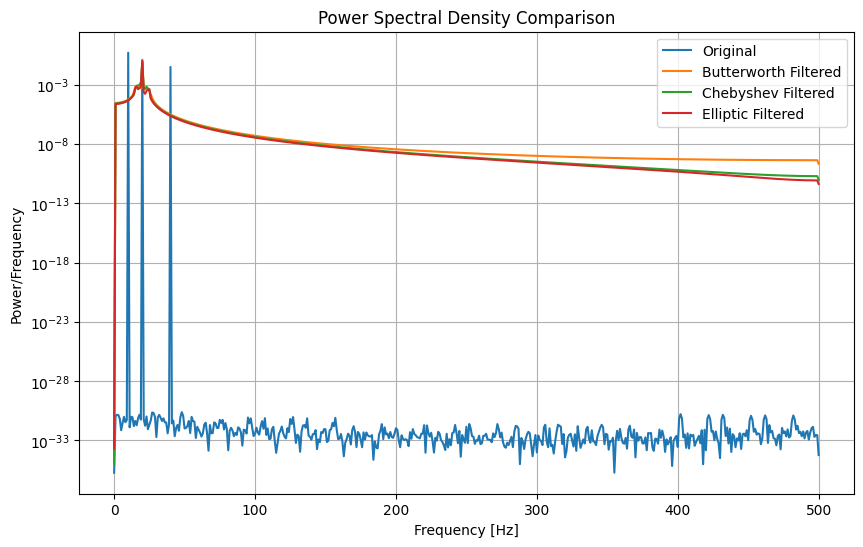

Filter Performance Metrics:


ValueError: image_true has intensity values outside the range expected for its data type. Please manually specify the data_range.

In [39]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def create_test_signal(t):
    """Create a test signal with multiple frequency components."""
    return (
        np.sin(2 * np.pi * 10 * t) +  # 10 Hz component
        0.5 * np.sin(2 * np.pi * 20 * t) +  # 20 Hz component
        0.25 * np.sin(2 * np.pi * 40 * t)  # 40 Hz component
    )

def design_bandpass_filter(filter_type, lowcut, highcut, fs, order=5):
    """Design a bandpass filter of the specified type."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    if filter_type == 'butterworth':
        b, a = signal.butter(order, [low, high], btype='band')
    elif filter_type == 'chebyshev':
        b, a = signal.cheby1(order, 1, [low, high], btype='band')
    elif filter_type == 'elliptic':
        b, a = signal.ellip(order, 1, 40, [low, high], btype='band')
    else:
        raise ValueError("Unsupported filter type")
    
    return b, a

def apply_filter(b, a, x):
    """Apply the filter to the input signal."""
    return signal.filtfilt(b, a, x)

def plot_frequency_response(b, a, fs, title):
    """Plot the frequency response of the filter."""
    w, h = signal.freqz(b, a, worN=8000)
    plt.figure(figsize=(10, 4))
    plt.semilogx(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)))
    plt.title(f'Frequency Response: {title}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.ylim(-100, 10)
    plt.grid(True)
    plt.show()

def plot_signals(t, original, filtered, title):
    """Plot the original and filtered signals."""
    plt.figure(figsize=(10, 4))
    plt.plot(t, original, label='Original')
    plt.plot(t, filtered, label='Filtered')
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
lowcut = 15  # Lower cutoff frequency (Hz)
highcut = 25  # Upper cutoff frequency (Hz)

# Create test signal
original_signal = create_test_signal(t)

# Design and apply filters
filter_types = ['butterworth', 'chebyshev', 'elliptic']
filtered_signals = {}

for filter_type in filter_types:
    b, a = design_bandpass_filter(filter_type, lowcut, highcut, fs)
    filtered_signals[filter_type] = apply_filter(b, a, original_signal)
    
    # Plot frequency response
    plot_frequency_response(b, a, fs, f'{filter_type.capitalize()} Bandpass Filter')
    
    # Plot original and filtered signals
    plot_signals(t, original_signal, filtered_signals[filter_type], 
                 f'{filter_type.capitalize()} Bandpass Filtered Signal')

# Compare filters in frequency domain
plt.figure(figsize=(10, 6))
f, Pxx_orig = signal.periodogram(original_signal, fs)
plt.semilogy(f, Pxx_orig, label='Original')

for filter_type in filter_types:
    f, Pxx_filt = signal.periodogram(filtered_signals[filter_type], fs)
    plt.semilogy(f, Pxx_filt, label=f'{filter_type.capitalize()} Filtered')

plt.title('Power Spectral Density Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("Filter Performance Metrics:")
for filter_type in filter_types:
    filtered = filtered_signals[filter_type]
    psnr_value = psnr(original_signal, filtered)
    ssim_value = ssim(original_signal, filtered, data_range=original_signal.max() - original_signal.min())
    snr = 10 * np.log10(np.sum(original_signal**2) / np.sum((original_signal - filtered)**2))
    
    print(f"\n{filter_type.capitalize()} Filter:")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print(f"SNR: {snr:.2f} dB")

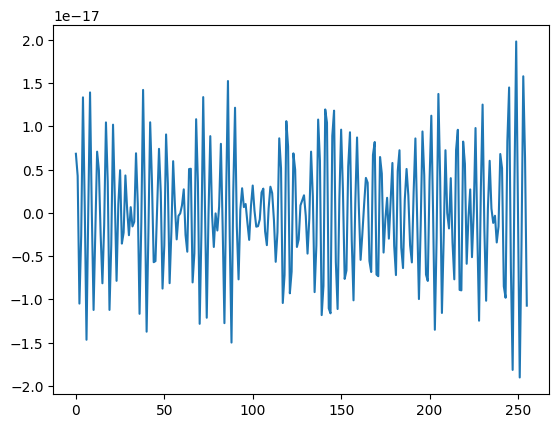

128


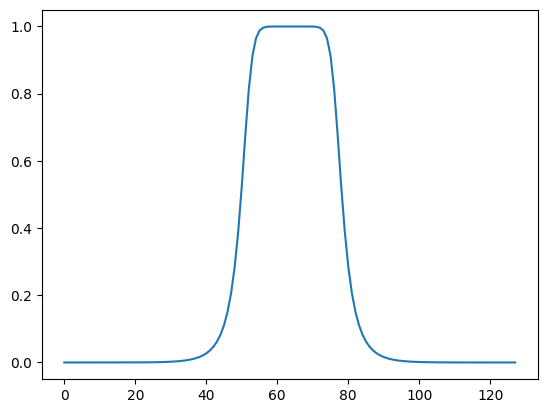

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
fs = 256  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
N = len(t)
bw = 0.1
lowcut = 64 - bw * fs/2  # Lower cutoff frequency (Hz)
highcut = 64 + bw * fs/2 # Upper cutoff frequency (Hz)

nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq

order=5
b, a = signal.butter(order, [low, high], btype='band')
#b, a = signal.cheby1(order, 1, [low, high], btype='band')
#b, a = signal.ellip(order, 1, 40, [low, high], btype='band')

x = np.ones(N)
y = signal.filtfilt(b, a, x)
plt.plot(y)
plt.show()

w, h = signal.freqz(b, a, worN=128)
print(len(h))
plt.plot(0.5 * fs * w / np.pi, np.abs(h))
plt.show()

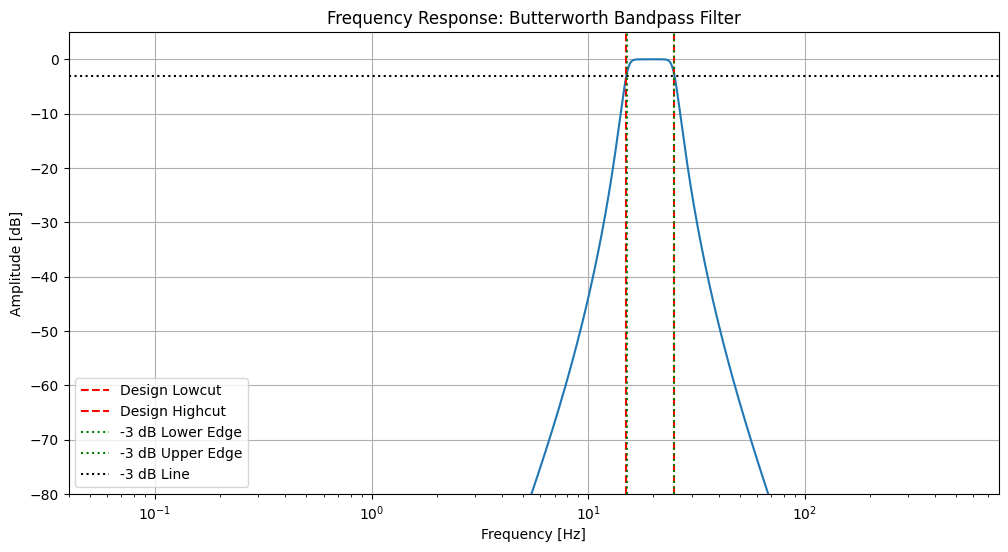

Passband Analysis for Butterworth Bandpass Filter:
Design specifications: 15.00 Hz - 25.00 Hz
-3 dB Passband: 15.06 Hz - 24.94 Hz
Passband width: 9.87 Hz
Deviation from design: Lower: 0.06 Hz, Upper: -0.06 Hz



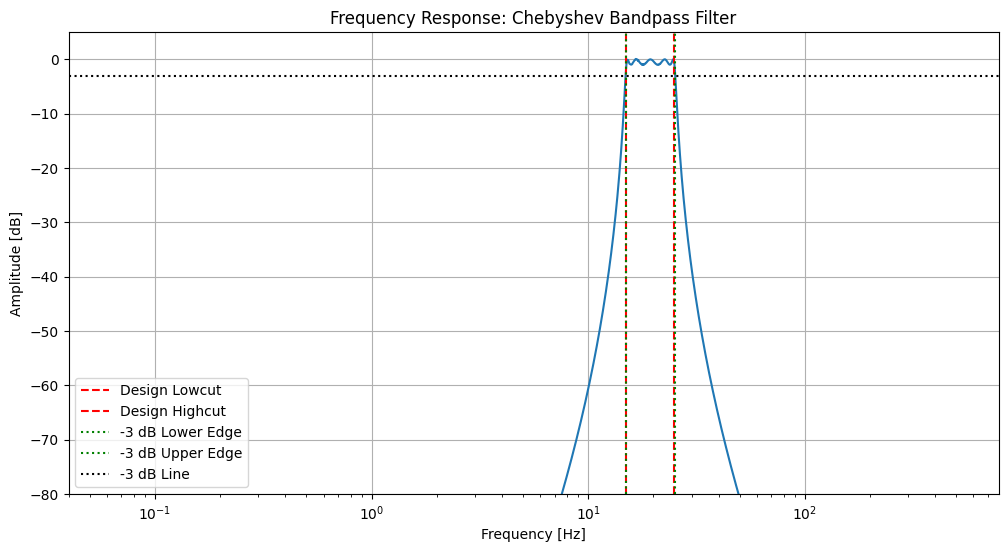

Passband Analysis for Chebyshev Bandpass Filter:
Design specifications: 15.00 Hz - 25.00 Hz
-3 dB Passband: 14.94 Hz - 25.19 Hz
Passband width: 10.25 Hz
Deviation from design: Lower: -0.06 Hz, Upper: 0.19 Hz



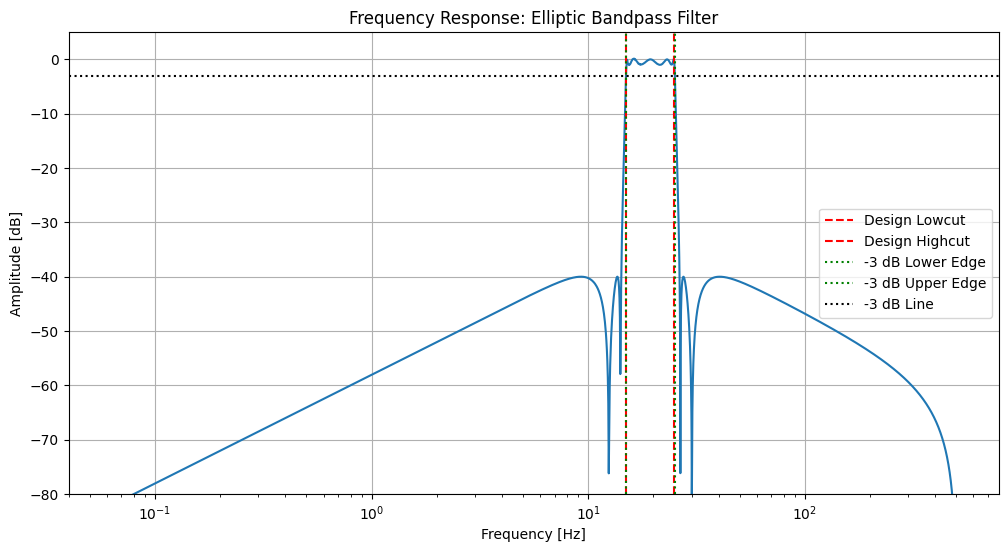

Passband Analysis for Elliptic Bandpass Filter:
Design specifications: 15.00 Hz - 25.00 Hz
-3 dB Passband: 15.00 Hz - 25.06 Hz
Passband width: 10.06 Hz
Deviation from design: Lower: 0.00 Hz, Upper: 0.06 Hz



In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def create_test_signal(t):
    """Create a test signal with multiple frequency components."""
    return (
        np.sin(2 * np.pi * 10 * t) +  # 10 Hz component
        0.5 * np.sin(2 * np.pi * 20 * t) +  # 20 Hz component
        0.25 * np.sin(2 * np.pi * 40 * t)  # 40 Hz component
    )

def design_bandpass_filter(filter_type, lowcut, highcut, fs, order=5):
    """Design a bandpass filter of the specified type."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    if filter_type == 'butterworth':
        b, a = signal.butter(order, [low, high], btype='band')
    elif filter_type == 'chebyshev':
        b, a = signal.cheby1(order, 1, [low, high], btype='band')
    elif filter_type == 'elliptic':
        b, a = signal.ellip(order, 1, 40, [low, high], btype='band')
    else:
        raise ValueError("Unsupported filter type")
    
    return b, a

def apply_filter(b, a, x):
    """Apply the filter to the input signal."""
    return signal.filtfilt(b, a, x)

def analyze_passband(w, h, fs):
    """Analyze the passband of the filter."""
    db = 20 * np.log10(np.abs(h))
    max_db = np.max(db)
    passband_mask = db >= max_db - 3
    passband_edges = w[passband_mask]
    if len(passband_edges) > 0:
        lower_edge = np.min(passband_edges)
        upper_edge = np.max(passband_edges)
        passband_width = upper_edge - lower_edge
        return (lower_edge * fs / (2 * np.pi), upper_edge * fs / (2 * np.pi), passband_width * fs / (2 * np.pi))
    else:
        return None, None, None

def plot_frequency_response(b, a, fs, lowcut, highcut, title):
    """Plot the frequency response of the filter with passband analysis."""
    w, h = signal.freqz(b, a, worN=8000)
    lower_edge, upper_edge, passband_width = analyze_passband(w, h, fs)
    
    plt.figure(figsize=(12, 6))
    plt.semilogx(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)))
    plt.title(f'Frequency Response: {title}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.ylim(-80, 5)
    plt.grid(True)
    
    # Plot design specifications
    plt.axvline(lowcut, color='r', linestyle='--', label='Design Lowcut')
    plt.axvline(highcut, color='r', linestyle='--', label='Design Highcut')
    
    # Plot -3 dB points
    if lower_edge and upper_edge:
        plt.axvline(lower_edge, color='g', linestyle=':', label='-3 dB Lower Edge')
        plt.axvline(upper_edge, color='g', linestyle=':', label='-3 dB Upper Edge')
        plt.axhline(-3, color='k', linestyle=':', label='-3 dB Line')
    
    plt.legend()
    plt.show()
    
    if lower_edge and upper_edge:
        print(f"Passband Analysis for {title}:")
        print(f"Design specifications: {lowcut:.2f} Hz - {highcut:.2f} Hz")
        print(f"-3 dB Passband: {lower_edge:.2f} Hz - {upper_edge:.2f} Hz")
        print(f"Passband width: {passband_width:.2f} Hz")
        print(f"Deviation from design: Lower: {lower_edge - lowcut:.2f} Hz, Upper: {upper_edge - highcut:.2f} Hz\n")

# ... [rest of the code remains the same] ...

# Parameters
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # 1 second of data
lowcut = 15  # Lower cutoff frequency (Hz)
highcut = 25  # Upper cutoff frequency (Hz)

# Create test signal
original_signal = create_test_signal(t)

# Design and apply filters
filter_types = ['butterworth', 'chebyshev', 'elliptic']
filtered_signals = {}

for filter_type in filter_types:
    b, a = design_bandpass_filter(filter_type, lowcut, highcut, fs)
    filtered_signals[filter_type] = apply_filter(b, a, original_signal)
    
    # Plot frequency response with passband analysis
    plot_frequency_response(b, a, fs, lowcut, highcut, f'{filter_type.capitalize()} Bandpass Filter')

# ... [rest of the code remains the same] ...